# Построение модели оптимизации производства, на примере золотодобывающего предприятия

## 1 Обзор и подготовка данных

### 1.1 Проведем обзор данных, изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st
import copy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

pd.set_option('display.max_columns', None)

#### Рассмотрим обучающую выборку

In [2]:
# Рассмотрим обучающую выборку
train = pd.read_csv('gold_recovery_train_new.csv')
display(train)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [3]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


<b>Вывод</b>

Изучив обучающую выборку можно сказать:

- таблица включает 14 149 строк и 87 столбцов;
- в большом количестве столбцов имеются пропуски, которые необходимо будет либо удалить, либо заполнить;
- типы данных в столбцах корректные (float), кроме столбца 'data', нужно будет заменить на тип datetime.

#### Рассмотрим тестовую выборку

In [4]:
# Рассмотрим тестовую выборку
test = pd.read_csv('gold_recovery_test_new.csv')
display(test)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [5]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [6]:
print(f'Соотношение обучающей и тестовой выборок: {len(test) / len(train)}')

Соотношение обучающей и тестовой выборок: 0.3738780125803944


<b>Вывод</b>

Изучив тестовую выборку можно сказать:

- таблица включает 5 290 строк и 53 столбцов;
- сразу можно заметить отсутствие 34 столбцов в сравнении с обучающей выборкой;
- в отличии от обучающей выборки в тестовой выборке вообще не представлены данные за 2018 год;
- соотношение объема обучающей и тестовой выборок составляет примерно 63% / 37%;
- пропусков в самих столбцах немного, их необходимо будет либо удалить, либо заполнить;
- типы данных в столбцах корректные (float), кроме столбца 'data', нужно будет заменить на тип datetime.

#### Рассмотрим исходные полные данные

In [7]:
# Рассмотрим исходные данные
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
display(full)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [8]:
print(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [9]:
print(f'Количество пропусков в столбце "secondary_cleaner.output.tail_sol" {1 - 17691/len(full)}')

Количество пропусков в столбце "secondary_cleaner.output.tail_sol" 0.08992232110705278


<b>Вывод</b>

Изучив обучающую выборку можно сказать:

- таблица включает 19 438 строк и 87 столбцов;
- в большом количестве столбцов имеются пропуски, например в столбце 'secondary_cleaner.output.tail_sol' почти 9% пропусков. Все эти пропуски необходимо будет либо удалить, либо заполнить.
- типы данных в столбцах корректные (float), кроме столбца 'data', нужно будет заменить на тип datetime.

### 1.2 Проверим правильность расчета эффективности обогащения. 

<b>Для этого вычислим эффективность обогащения на обучающей выборке для признака rougher.output.recovery по формуле. Затем найдем MAE между нашими расчётами и значением признака. Опишем выводы.</b>

In [10]:
recovery_list = [] # массив значений эффективности обогащения, расчитанных по формуле
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

for i in range(len(train)):
    recovery = (C[i]*(F[i]-T[i])) / (F[i]*(C[i]-T[i]))*100
    recovery_list.append(recovery)

In [12]:
# Выделим в обучающей выборке features и target
target_train = train['rougher.output.recovery']
features_train = train.drop(['date', 'rougher.output.recovery'], axis=1)

In [13]:
# Вычислим МАЕ
mae = mean_absolute_error(target_train, recovery_list)
print(f'Среднее абсолютное отклонение MAE: {mae}')

Среднее абсолютное отклонение MAE: 9.73512347450521e-15


<b>Вывод</b>

В ходе проведенных расчетов найдена эффективность обогащения (recovery_list) на обучающей выборке для признака rougher.output.recovery с помощью формулы, а затем получено среднее абсолютное отклнение MAE между полученными данными и значением признака rougher.output.recovery.
Значений MAE чрезвычайно низкое, близкое к нулю (9.73512347450521e-15), что говорит о практически нулевом среднем абсолютном отклонении значений расчитанных по формуле и значений в таблице. Из этого можно сделать вывод, что <b>расчет эффективности обогащения является правильным<b/>.

### 1.3 Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [20]:
# найдем все отсутствующие столбцы в тестовой выборке
df = train.drop(test.columns, axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                                14149 non-null  float64


<b>Вывод</b>

В ходе изучения тестовой выборки мы смогли заметить отсутствие 34 столбцов в сравнении с обучающей выборкой. В тестовой выборке отсутствуют:
- все колонки, имеющие информацию о выходном продукте после каждой операции и расчетные характеристики на этапе флотации;
- из них все 9 столбцов, отвечающих за финальный этап переработки;
- кроме того, в отличии от обучающей выборки в тестовой выборке вообще не представлены данные за 2018 год.

Все отсутствующие данные имеют тип float.

### 1.4 Проведем предобработку данных

#### Работа с пропусками

    Обучающая выборка

In [21]:
train_1 = train.dropna()
print(train_1.info(verbose = False)) # краткая информационная справка по таблице

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 14148
Columns: 87 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86), object(1)
memory usage: 7.4+ MB
None


<b>Во многих столбцах таблицы имеются пропуски, но исключать эти пропуски как оказалось нельзя, потому что потеря данных будет существенной: из 14148 объектов останется 11017.</b>

<b>Думаю будет правильно заменить пропуски на предыдущие значения.</b>

In [22]:
train = train.fillna(method = 'ffill')
print(train.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Columns: 87 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86), object(1)
memory usage: 9.4+ MB
None


    Тестовая выборка

In [23]:
# Заполним пропуски предыдущими не пустыми значениями
test = test.fillna(method = 'ffill')
print(test.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Columns: 53 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(52), object(1)
memory usage: 2.1+ MB
None


    Исходные данные

In [24]:
full_1 = full.dropna()
print(full_1.info(verbose = False)) # краткая информационная справка по таблице

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16094 entries, 0 to 19438
Columns: 87 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86), object(1)
memory usage: 10.8+ MB
None


<b>Во многих столбцах таблицы имеются пропуски, но исключать эти пропуски как оказалось нельзя, потому что потеря данных будет существенной: из 19 438 объектов останется 16 094.</b>

<b>Думаю будет правильно заменить пропуски на предыдущие значения.</b>

In [25]:
# Заполним пропуски предыдущими не пустыми значениями
full = full.fillna(method = 'ffill')
print(full.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Columns: 87 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86), object(1)
memory usage: 12.9+ MB
None


<b>Вывод</b>

Все пропуски во всех трех таблицах были заменены на предыдущие значения.

#### Изменение типов данных

In [26]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d %H:%M:%S')
print(train.dtypes)

date                                          datetime64[ns]
final.output.concentrate_ag                          float64
final.output.concentrate_pb                          float64
final.output.concentrate_sol                         float64
final.output.concentrate_au                          float64
                                                   ...      
secondary_cleaner.state.floatbank5_a_level           float64
secondary_cleaner.state.floatbank5_b_air             float64
secondary_cleaner.state.floatbank5_b_level           float64
secondary_cleaner.state.floatbank6_a_air             float64
secondary_cleaner.state.floatbank6_a_level           float64
Length: 87, dtype: object


In [27]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
print(test.dtypes)

date                                          datetime64[ns]
primary_cleaner.input.sulfate                        float64
primary_cleaner.input.depressant                     float64
primary_cleaner.input.feed_size                      float64
primary_cleaner.input.xanthate                       float64
primary_cleaner.state.floatbank8_a_air               float64
primary_cleaner.state.floatbank8_a_level             float64
primary_cleaner.state.floatbank8_b_air               float64
primary_cleaner.state.floatbank8_b_level             float64
primary_cleaner.state.floatbank8_c_air               float64
primary_cleaner.state.floatbank8_c_level             float64
primary_cleaner.state.floatbank8_d_air               float64
primary_cleaner.state.floatbank8_d_level             float64
rougher.input.feed_ag                                float64
rougher.input.feed_pb                                float64
rougher.input.feed_rate                              float64
rougher.input.feed_size 

In [28]:
full['date'] = pd.to_datetime(full['date'], format='%Y-%m-%d %H:%M:%S')
print(full.dtypes)

date                                          datetime64[ns]
final.output.concentrate_ag                          float64
final.output.concentrate_pb                          float64
final.output.concentrate_sol                         float64
final.output.concentrate_au                          float64
                                                   ...      
secondary_cleaner.state.floatbank5_a_level           float64
secondary_cleaner.state.floatbank5_b_air             float64
secondary_cleaner.state.floatbank5_b_level           float64
secondary_cleaner.state.floatbank6_a_air             float64
secondary_cleaner.state.floatbank6_a_level           float64
Length: 87, dtype: object


## 2 Анализ данных

### 2.1 Проанализируем, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишем выводы.

Просматривать, как меняется концентрация металлов (Au, Ag, Pb) будем на следующих этапах:
1. до этапа флотации - концентрация металлов в исходном сырье, столбцы:
    - rougher.input.feed_ag,
    - rougher.input.feed_pb,
    - rougher.input.feed_au.
2. после этапа флотации - концентрация металлов в концентрате после флотации, столбцы:
    - rougher.output.concentrate_ag,
    - rougher.output.concentrate_pb,
    - rougher.output.concentrate_au.
3. после этапа первичной очистки - концентрация металлов в концентрате после первичной очистки, столбцы:
    - primary_cleaner.output.concentrate_ag,
    - primary_cleaner.output.concentrate_pb,
    - primary_cleaner.output.concentrate_au.
4. после этапа вторичной очистки - концентрация металлов в финальном концентрате после вторичной очистки, столбцы:
    - final.output.concentrate_ag,
    - final.output.concentrate_pb,
    - final.output.concentrate_au.      

<b>Исходное сырье</b>

In [29]:
tr_rougher_feed = train[['rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_pb']]
tr_rougher_feed.columns = ['Серебро', 'Золото', 'Свинец']

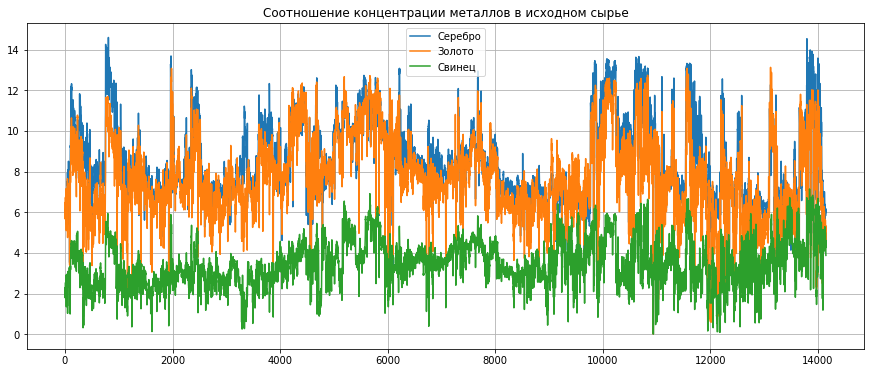

In [30]:
tr_rougher_feed.plot(grid=True, figsize=(15, 6), title='Соотношение концентрации металлов в исходном сырье')
plt.show()

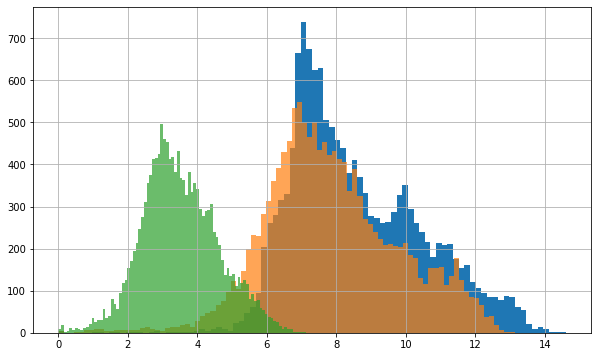

In [31]:
# Гистограмма распределения концентрации металлов в сырье
tr_rougher_feed['Серебро'].hist(bins=90, figsize=(10, 6))
tr_rougher_feed['Золото'].hist(bins=90, alpha=.7, figsize=(10, 6))
tr_rougher_feed['Свинец'].hist(bins=90, alpha=.7, figsize=(10, 6))
plt.title = 'Гистограммы распределения концентрации металлов в сырье'
plt.xlable = 'Концентрации'
plt.ylable = 'Частота'

<b>Концентрат после флотации</b>

In [32]:
tr_rougher_concentrate = train[['rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb']]
tr_rougher_concentrate.columns = ['Серебро', 'Золото', 'Свинец']
#display(tr_rougher_concentrate)

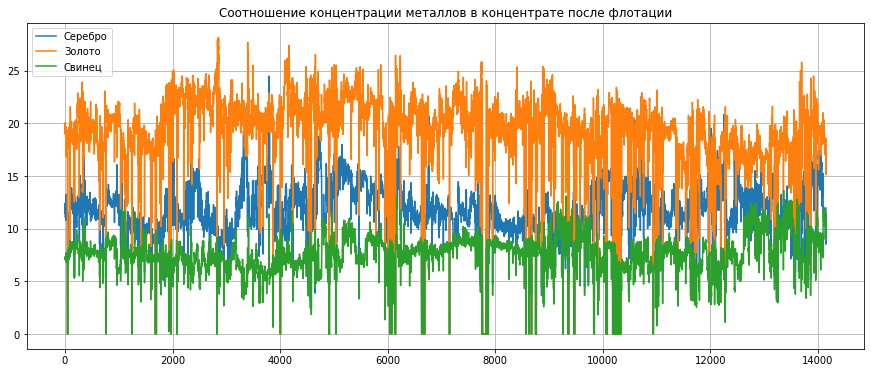

In [33]:
tr_rougher_concentrate.plot(grid=True, figsize=(15, 6), title='Соотношение концентрации металлов в концентрате после флотации')
plt.show()

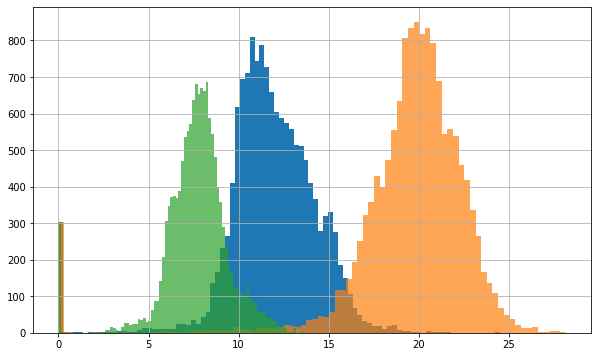

In [34]:
# Гистограмма распределения концентрации металлов в концентрате после флотации
tr_rougher_concentrate['Серебро'].hist(bins=90, figsize=(10, 6))
tr_rougher_concentrate['Золото'].hist(bins=90, alpha=.7, figsize=(10, 6))
tr_rougher_concentrate['Свинец'].hist(bins=90, alpha=.7, figsize=(10, 6))
plt.title = 'Гистограммы распределения концентрации металлов в концентрате после флотации'
plt.xlable = 'Концентрации'
plt.ylable = 'Частота'

<b>Концентрат после первичного этапа очистки</b>

In [35]:
tr_primary_concentrate = train[['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb']]
tr_primary_concentrate.columns = ['Серебро', 'Золото', 'Свинец']
#display(tr_primary_concentrate)

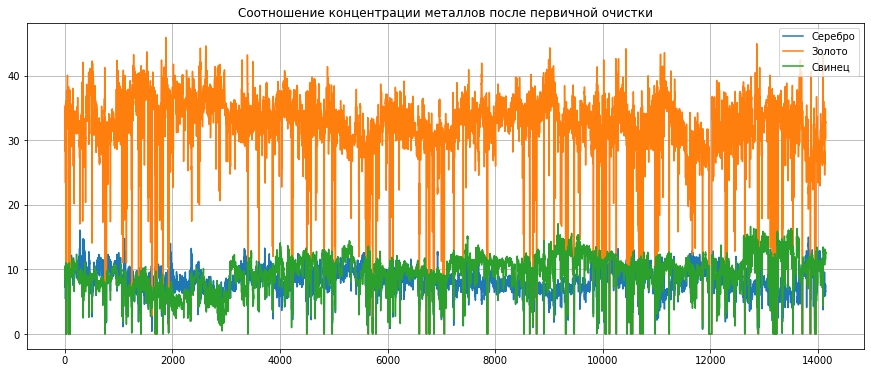

In [36]:
tr_primary_concentrate.plot(grid=True, figsize=(15, 6), title='Соотношение концентрации металлов после первичной очистки')
plt.show()

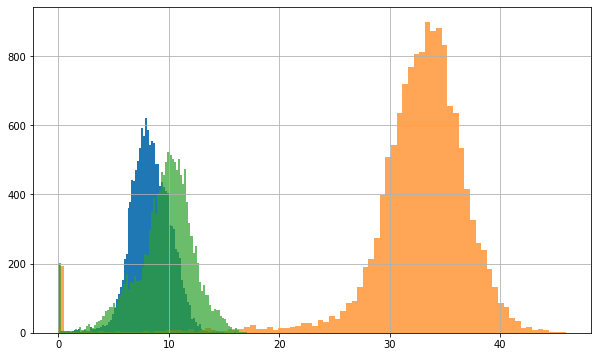

In [37]:
# Гистограмма распределения концентрации металлов после первичной очистки
tr_primary_concentrate['Серебро'].hist(bins=90, figsize=(10, 6))
tr_primary_concentrate['Золото'].hist(bins=90, alpha=.7, figsize=(10, 6))
tr_primary_concentrate['Свинец'].hist(bins=90, alpha=.7, figsize=(10, 6))
plt.title = 'Гистограммы распределения концентрации металлов после первичной очистки'
plt.xlable = 'Концентрации'
plt.ylable = 'Частота'

<b>Финальный концентрат</b>

In [38]:
tr_final_concentrate = train[['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb']]
tr_final_concentrate.columns = ['Серебро', 'Золото', 'Свинец']
#display(tr_final_concentrate)

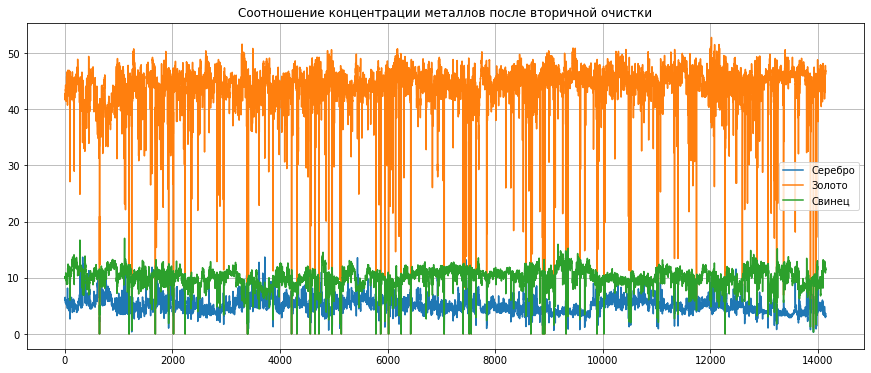

In [39]:
tr_final_concentrate.plot(grid=True, figsize=(15, 6), title='Соотношение концентрации металлов после вторичной очистки')
plt.show()

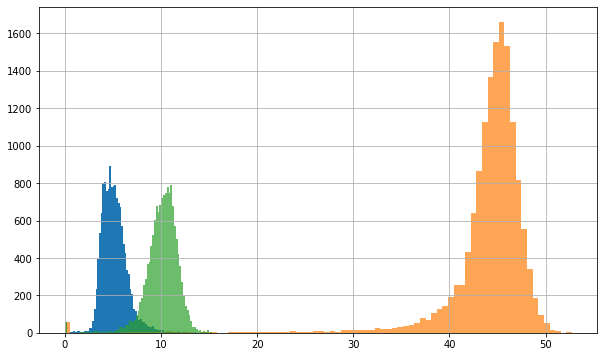

In [40]:
# Гистограмма распределения концентрации металлов после вторичной очистки
tr_final_concentrate['Серебро'].hist(bins=90, figsize=(10, 6))
tr_final_concentrate['Золото'].hist(bins=90, alpha=.7, figsize=(10, 6))
tr_final_concentrate['Свинец'].hist(bins=90, alpha=.7, figsize=(10, 6))
plt.title = 'Гистограммы распределения концентрации металлов после вторичной очистки'
plt.xlable = 'Концентрации'
plt.ylable = 'Частота'

<b>Вывод</b>

Просматривая все четыре графика и диаграммы распределения и переходя от этапа к этапу можно увидеть как меняется на протяжении всего цикла обработки концентрация металлов как в отношении друг к другу, так и в числовом значении:
   - Необработанное сырье имеет небольшую концентрацию всех трех металлов, при этом концентрация золота и серебра почти в 2 раза выше свинца.
   - Уже после этапа флотации концентрация всех металлов возрастает почти вдвое, а золота почти в 3 раза. Соотношение металлов тоже меняется и золото выходит на первое место и уходит в отрыв.
   - После первой очистки отрыв золота от серебра со свинцом существенно выростает, при этом концентрация его увеличивается еще почти вдвое, а концентрация серебра и свинца остается прежней.
   - Финальный концентрат характеризуется еще большей концентрацией золота, а также небольшим снижением концентрации серебра.

<b>Распределение средних значений концентраций металлов на каждом этапе</b>

In [41]:
tr_concentrate = train[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au',
                            'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au',
                            'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au', 
                            'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']]
#display(tr_concentrate)

tr_concentrate_mean = tr_concentrate.mean()
display(pd.DataFrame(tr_concentrate_mean))

tr_concentrate_mean = pd.DataFrame(tr_concentrate_mean).T
display(tr_concentrate_mean)

,0
rougher.input.feed_ag,8.579195
rougher.input.feed_pb,3.505465
rougher.input.feed_au,7.866577
rougher.output.concentrate_ag,11.775812
rougher.output.concentrate_pb,7.664555
rougher.output.concentrate_au,19.439958
primary_cleaner.output.concentrate_ag,8.200916
primary_cleaner.output.concentrate_pb,9.568544
primary_cleaner.output.concentrate_au,32.386836
final.output.concentrate_ag,5.141921


,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_au
0,8.579195,3.505465,7.866577,11.775812,7.664555,19.439958,8.200916,9.568544,32.386836,5.141921,10.132848,44.003792


In [42]:
data = {'Этапы': ['feed', 'rougher', 'primary', 'final'], 
       'Серебро': [8.579195, 11.775812, 8.200916, 5.141921], 'Золото': [7.866577, 19.439958, 32.386836, 44.003792],
       'Свинец': [3.505465, 7.6645552, 9.568544, 10.132848]}

metalls = pd.DataFrame(data)
display(metalls)

,Этапы,Серебро,Золото,Свинец
0,feed,8.579195,7.866577,3.505465
1,rougher,11.775812,19.439958,7.664555
2,primary,8.200916,32.386836,9.568544
3,final,5.141921,44.003792,10.132848


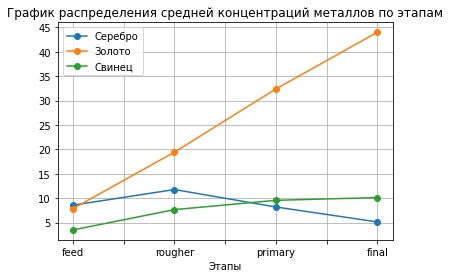

In [43]:
metalls.plot(kind='line', style='o-', x='Этапы', grid=True,
             title = 'График распределения средней концентраций металлов по этапам')
plt.show()

### 2.2 Проведем сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. 

<b>Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.</b>

#### Выделим признаки, отвечающие за размер гранул сырья в обучающей и тестовой выборках

In [44]:
# Признаки, отвечающие за размер гранул сырья в обучающей выборке (rougher.input.feed_size, primary_cleaner.input.feed_size)
# предполагаю, что размер гранул дается в мм
train_rougher_fsize = train['rougher.input.feed_size'] # размер гранул исходного сырья в обучающей выборке
train_primary_fsize = train['primary_cleaner.input.feed_size'] # размер гранул сырья перед первичной очисткой в обучающей выборке
display(train_rougher_fsize, train_primary_fsize)

0         55.486599
1         57.278666
2         57.510649
3         57.792734
4         56.047189
            ...    
14144     85.718304
14145    119.499241
14146    122.262690
14147    123.742430
14148     94.544358
Name: rougher.input.feed_size, Length: 14149, dtype: float64

0        7.25
1        7.25
2        7.25
3        7.25
4        7.25
         ... 
14144    6.50
14145    6.50
14146    6.50
14147    6.50
14148    6.50
Name: primary_cleaner.input.feed_size, Length: 14149, dtype: float64

In [45]:
# Признаки, отвечающие за размер гранул сырья в тестовой выборке (rougher.input.feed_size, primary_cleaner.input.feed_size)
test_rougher_fsize = test['rougher.input.feed_size'] # размер гранул исходного сырья в обучающей выборке
test_primary_fsize = test['primary_cleaner.input.feed_size'] # размер гранул сырья перед первичной очисткой в обучающей выборке
display(test_rougher_fsize, test_primary_fsize)

0       62.710452
1       61.961163
2       66.903807
3       59.865919
4       63.315324
          ...    
5285    66.758479
5286    62.560684
5287    73.647513
5288    78.066446
5289    77.678700
Name: rougher.input.feed_size, Length: 5290, dtype: float64

0       8.080000
1       8.080000
2       7.786667
3       7.640000
4       7.530000
          ...   
5285    8.070000
5286    8.070000
5287    8.070000
5288    8.070000
5289    8.070000
Name: primary_cleaner.input.feed_size, Length: 5290, dtype: float64

#### Построим гистограммы распределения размеров гранул исходного сырья по данным обучающей и тестовой выборках на одном графике

Обучающая выборка: 
count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Тестовая выборка: 
count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64


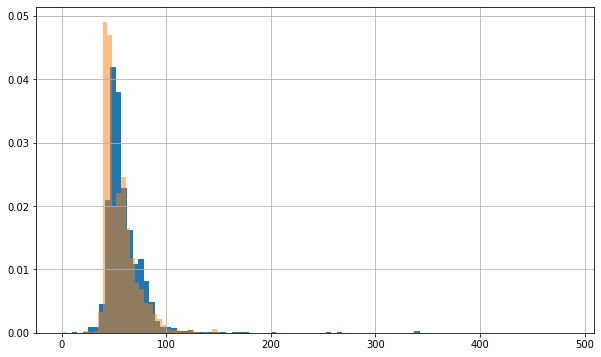

In [46]:
print(f'Обучающая выборка: \n{train_rougher_fsize.describe()}')
print()
print(f'Тестовая выборка: \n{test_rougher_fsize.describe()}')
train_rougher_fsize.hist(bins=90, figsize=(10, 6), density=True)
test_rougher_fsize.hist(bins=90, alpha=.5, figsize=(10, 6), density=True)
plt.title = 'Гистограммы распределения частот распределения размеров гранул сырья'
plt.xlable = 'Размер гранул'
plt.ylable = 'Частота'

<b>Вывод</b>

Проанализировав гистограммы распределения размеров гранул исходного сырья до флотации по данным обучающей и тестовой выборках можно заметить схожесть форм гистограмм и места размещения на оси х (размеры гранул). Кроме того, такие значения как максимальные и минимальные точки, средние и медианы, а также 2-й и 3-й квартили довольно близки для обоих выборок. Выбросы также имеют схожий характер.

Думаю можно назвать эти две выборки схожими.

#### Построим гистограммы распределения размеров гранул сырья перед первичной обработкой по данным обучающей и тестовой выборках на одном графике

Обучающая выборка: 
count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

Тестовая выборка: 
count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64


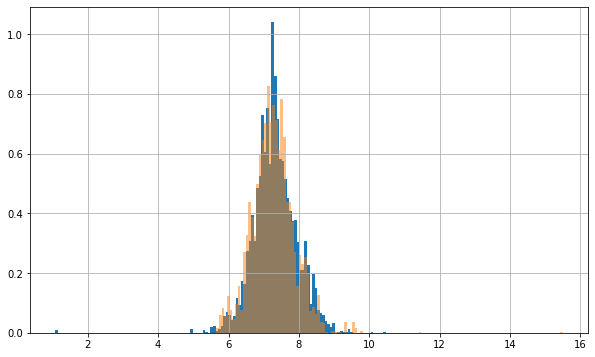

In [47]:
print(f'Обучающая выборка: \n{train_primary_fsize.describe()}')
print()
print(f'Тестовая выборка: \n{test_primary_fsize.describe()}')
train_primary_fsize.hist(bins=130, figsize=(10, 6), density=True) # density=True в hist переводит абсолютные показатели 
test_primary_fsize.hist(bins=130, alpha=.5, figsize=(10, 6), density=True) # количества в относительные (ось у)
plt.title = 'Гистограммы распределения размеров гранул сырья'
plt.xlable = 'Размер гранул'
plt.ylable = 'Частота'

<b>Вывод</b>

Проанализировав гистограммы распределения размеров гранул сырья перед этапом первичной очистки по данным обучающей и тестовой выборках можно заметить большую схожесть форм гистограмм и места размещения на оси х (размеры гранул). Кроме того, такие значения как максимальные и минимальные точки, средние и медианы, а также 2-й и 3-й квартили очень близки для обоих выборок. Выбросы также имеют схожий характер. Различия здесь, как и на диаграмме распределения распределения размеров гранул исходного сырья имеются только в высоте гистограмм, но это законормерно, т.к. размер тестовой выборки существенно ниже размера обучающей выборки.

Думаю можно определенно назвать эти две выборки схожими. Оценка модели в пункте 3 должна быть верной.

### 2.3 Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

<b>Для иследования будет использоваться полная выборка с исходными данными</b>

#### Найдем суммарную концентрацию металлов на разных стадиях

Исследовать, как меняется суммарная концентрация металлов (Au, Ag, Pb) будем на следующих стадиях:
1. до этапа флотации - суммарная концентрация металлов в исходном сырье, столбцы:
    - rougher.input.feed_ag,
    - rougher.input.feed_pb,
    - rougher.input.feed_au.
    
    
2. после этапа флотации - суммарная концентрация металлов в черновом концентрате после флотации, столбцы:
    - rougher.output.concentrate_ag,
    - rougher.output.concentrate_pb,
    - rougher.output.concentrate_au.


3. после этапа вторичной очистки - суммарная концентрация металлов в финальном концентрате после вторичной очистки, столбцы:
    - final.output.concentrate_ag,
    - final.output.concentrate_pb,
    - final.output.concentrate_au.      

In [48]:
# Найдем суммарную концентрацию металлов в исходном сырье до этапа флотации
full_rougher_feed_sum = full['rougher.input.feed_ag'] + full['rougher.input.feed_pb'] + full['rougher.input.feed_au']
display(full_rougher_feed_sum)

0        14.871440
1        14.905729
2        14.638299
3        14.199305
4        13.511497
           ...    
19434    16.045275
19435    15.104931
19436    14.515579
19437    14.313448
19438    14.399936
Length: 19439, dtype: float64

In [49]:
# Найдем суммарную концентрацию металлов в черновом концентрате
full_rougher_concentrate_sum = full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_au']
display(full_rougher_concentrate_sum)

0        38.395653
1        38.945647
2        38.649756
3        38.411473
4        38.867359
           ...    
19434    40.712449
19435    40.755632
19436    32.589863
19437    40.148948
19438    40.465768
Length: 19439, dtype: float64

In [50]:
# Найдем суммарную концентрацию металлов в финальном концентрате
full_final_concentrate_sum = full['final.output.concentrate_ag'] + full['final.output.concentrate_pb'] + full['final.output.concentrate_au']
display(full_final_concentrate_sum)

0        58.137072
1        58.699942
2        58.927421
3        58.714815
4        59.065251
           ...    
19434    61.295107
19435    61.412113
19436    61.340054
19437    61.401016
19438    61.635645
Length: 19439, dtype: float64

#### Построим диаграммы распределения суммарных концентраций металлов на разных стадиях

Исходное сырье: 
count    19439.000000
mean        20.646120
std          4.480027
min          0.030000
25%         17.252879
50%         20.141216
75%         23.797381
max         33.498784
dtype: float64

Черновой концентрат: 
count    19439.000000
mean        39.373032
std          6.863389
min          0.000000
25%         38.394639
50%         40.312648
75%         42.365102
max         55.568687
dtype: float64

Финальный концентрат: 
count    19439.000000
mean        59.223721
std          6.095138
min          0.000000
25%         59.298323
50%         60.306921
75%         61.096667
max         64.968881
dtype: float64


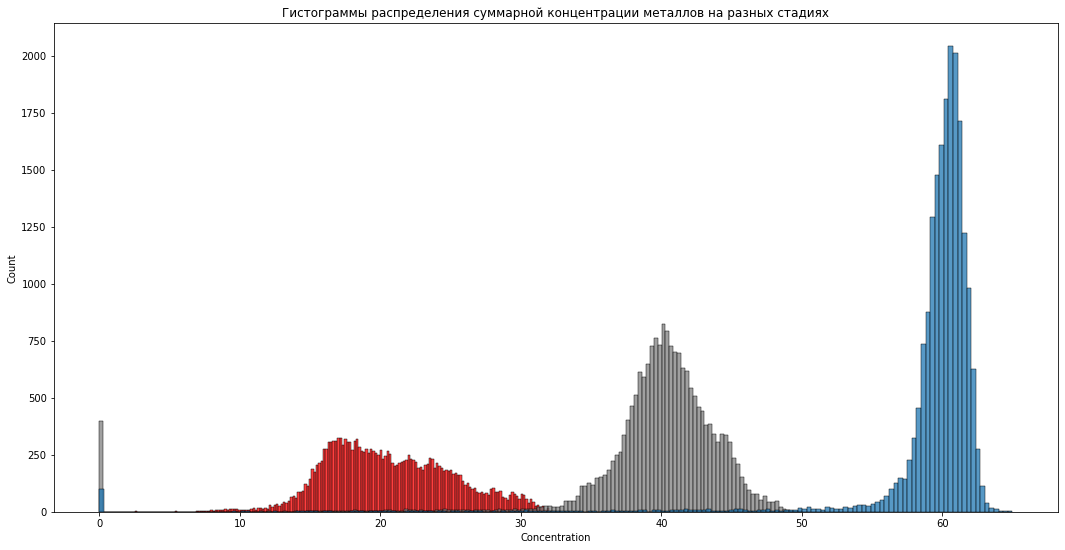

In [51]:
print(f'Исходное сырье: \n{full_rougher_feed_sum.describe()}')
print()
print(f'Черновой концентрат: \n{full_rougher_concentrate_sum.describe()}')
print()
print(f'Финальный концентрат: \n{full_final_concentrate_sum.describe()}')
full_rougher_feed_sum = pd.DataFrame(full_rougher_feed_sum) # для отображения названия 'Concentration' по оси х
full_rougher_feed_sum.columns = ['Concentration'] # для отображения названия 'Concentration' по оси х
#display(full_rougher_feed_sum)
plt.figure(figsize=(18,9))
plt.grid=True
a = sns.histplot(data=full_rougher_feed_sum, bins=200, color='red', x='Concentration', legend=True).set(
    title='Гистограммы распределения суммарной концентрации металлов на разных стадиях') # распределение в исходном сырье
d = sns.histplot(data=full_rougher_concentrate_sum, bins=200, color='grey') # распределение в черновом концентрате
c = sns.histplot(data=full_final_concentrate_sum, bins=200) # распределение в финальном концентрате

plt.show()

<b>Вывод</b>

Проанализировав гистограммы распределения суммарной концентрации металлов на разных стадиях процесса переработки можно увидеть большой прирост концентрации на каждой стадии (почти на 20%). Значения концентрации в черновом и финальном равные 0% встречаются довольно часто. Размах значений концентрации от стадии к стадии уменьшается. Среднее значение концентрации на растет, это видно и из гисторгамм и описания (describe()). Форма гистограмм распределения для чернового и финального концентратов близки к нормальному.

Поведение гистограмм распределения соответствует изменениям в процессе переработки от стадии к стадии.

<b>Считаю, что имеются аномальные явления: на стадиях получения чернового и финального концентратов имеется большое количество нулевых значений (это видно на гистограмме выше).
    
Посчитаем количество нулевых значений суммарной концентрации в черновом концентрате.</b>

In [52]:
full_concentrate = full[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au',
                            'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au',
                        'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']]
full_concentrate.columns = ('rougher_input_feed_ag', 'rougher_input_feed_pb', 'rougher_input_feed_au',
                            'rougher_output_concentrate_ag', 'rougher_output_concentrate_pb', 'rougher_output_concentrate_au',
                        'final_output_concentrate_ag', 'final_output_concentrate_pb', 'final_output_concentrate_au')

rougher_output_0 = full_concentrate.query('rougher_output_concentrate_ag == 0 and rougher_output_concentrate_pb == 0 and rougher_output_concentrate_au == 0')
display(rougher_output_0)

,rougher_input_feed_ag,rougher_input_feed_pb,rougher_input_feed_au,rougher_output_concentrate_ag,rougher_output_concentrate_pb,rougher_output_concentrate_au,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_au
45,7.521974,2.811569,7.114065,0.0,0.0,0.0,4.566664,10.406178,46.614456
46,7.313187,2.973841,7.651522,0.0,0.0,0.0,4.577832,10.691605,46.250638
47,7.934791,1.763437,5.587750,0.0,0.0,0.0,4.591462,10.628846,46.663335
48,7.756881,1.025762,4.752992,0.0,0.0,0.0,5.296830,10.597469,44.015642
49,5.393466,1.824835,5.122801,0.0,0.0,0.0,8.162896,8.877528,40.715973
...,...,...,...,...,...,...,...,...,...
15620,8.576019,2.607144,7.951063,0.0,0.0,0.0,4.909904,9.941006,47.660737
15621,8.640039,2.905023,8.715784,0.0,0.0,0.0,4.797572,9.889303,47.801056
15622,8.769059,3.020251,9.026122,0.0,0.0,0.0,4.329492,9.413122,49.412576
15623,8.705607,2.881386,8.752430,0.0,0.0,0.0,4.317169,9.642271,48.839994


Количество нулевых значений суммарной концентрации в черновом концентрате получилось равно 394.

Предполагаю, что можно выкинуть из обучающей, тестовой и полной выборок строки где суммарная концентрация в черновом и финальном концентратах равна 0 и построить гистограммы вновь.

<b>Нулевые значения в таблицах имеются сразу в 3-х столбцах для чернового концентрата ('rougher.output.concentrate_au', rougher.output.concentrate_pb', 'rougher.output.concentrate_au'), значит достаточно сделать выборку по одному из них. 

Тоже самое и для финального концентрата.</b>

In [53]:
# удалим из полной выборки значения концентрации металлов в черновом и финальном концентратах равные 0 

full_nonzero = full.loc[full.loc[:, 'rougher.output.concentrate_au'] != 0]
full_nonzero = full_nonzero.loc[full_nonzero.loc[:, 'final.output.concentrate_au'] != 0]
display(full_nonzero)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [54]:
# удалим из обучающей выборки значения концентрации металлов в черновом и финальном концентратах равные 0 

train_nonzero = train.loc[train.loc[:, 'rougher.output.concentrate_au'] != 0]
train_nonzero = train_nonzero.loc[train_nonzero.loc[:, 'final.output.concentrate_au'] != 0]
display(train_nonzero)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<b>Тестовую выборку оставляем как есть, т.к. в ней нет столбцов со значениями концентрации металлов в черновом и финальном концентратах.</b>

#### Найдем суммарную концентрацию металлов на разных стадиях и построим гистограммы распределения с учетом удаления нулевых значений для суммарных концентраций (используем полную выборку)

In [55]:
# Найдем суммарную концентрацию металлов в исходном сырье до этапа флотации
full_rougher_feed_sum_1 = full_nonzero['rougher.input.feed_ag'] + full_nonzero['rougher.input.feed_pb'] + full_nonzero['rougher.input.feed_au']
# display(full_rougher_feed_sum)

# Найдем суммарную концентрацию металлов в черновом концентрате
full_rougher_concentrate_sum_1 = full_nonzero['rougher.output.concentrate_ag'] + full_nonzero['rougher.output.concentrate_pb'] + full_nonzero['rougher.output.concentrate_au']
# display(full_rougher_concentrate_sum)

# Найдем суммарную концентрацию металлов в финальном концентрате
full_final_concentrate_sum_1 = full_nonzero['final.output.concentrate_ag'] + full_nonzero['final.output.concentrate_pb'] + full_nonzero['final.output.concentrate_au']
# display(full_final_concentrate_sum)

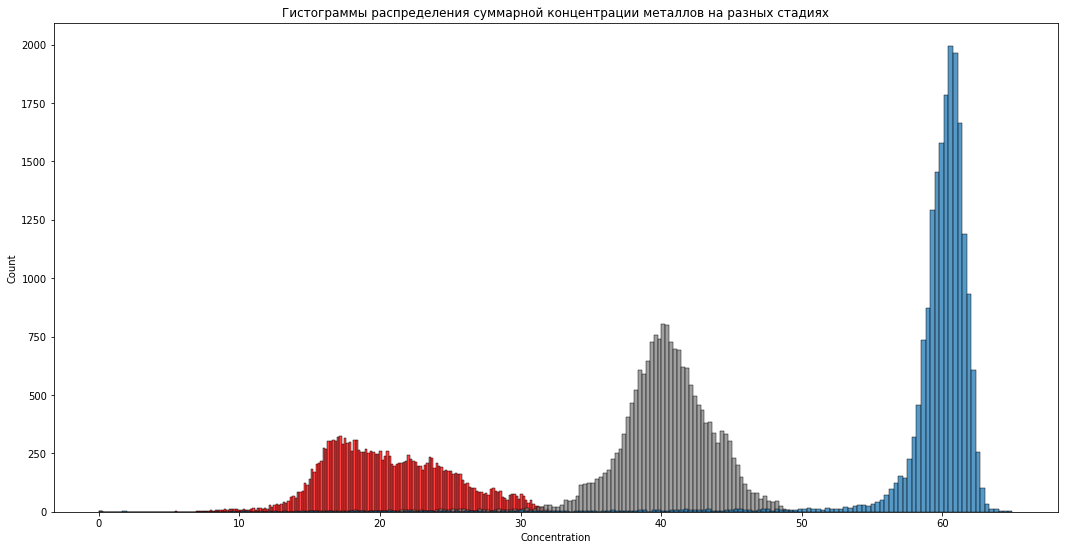

In [56]:
full_rougher_feed_sum_1 = pd.DataFrame(full_rougher_feed_sum_1) # для отображения названия 'Concentration' по оси х
full_rougher_feed_sum_1.columns = ['Concentration'] # для отображения названия 'Concentration' по оси х

plt.figure(figsize=(18,9))
plt.grid=True
a = sns.histplot(data=full_rougher_feed_sum_1, bins=200, color='red', x='Concentration', legend=True).set(
    title='Гистограммы распределения суммарной концентрации металлов на разных стадиях') # распределение в исходном сырье
d = sns.histplot(data=full_rougher_concentrate_sum_1, bins=200, color='grey') # распределение в черновом концентрате
c = sns.histplot(data=full_final_concentrate_sum_1, bins=200) # распределение в финальном концентрате

plt.show()

<b>Вывод</b>

В данной гистограмме распределения видно, что аномалии с нулевыми значениями уже нет.

Поведение гистограмм распределения соответствует изменениям в процессе переработки от стадии к стадии.

## 3 Построение модели

### 3.1 Напишем функцию для вычисления итоговой sMAPE

#### Напишем функцию для вычисления итоговой sMAPE

In [57]:
def smape(target, prediction):
    return 1/len(target) * sum(2*abs(target-prediction) / (abs(target)+abs(prediction))) * 100

### 3.2 Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.

#### 3.2.1 Модель Линейной регрессии

#### Найдем предсказания для обучающей выборки на модели линейной регресии

In [58]:
# Выделим из обучающей выборки признаки (features) и целевые признаки (target)
target_train_nonzero = train_nonzero[['rougher.output.recovery', 'final.output.recovery']]

# Уберем из обучающей выборки все отсутствующие в тестовой выборке столбцы:
features_train_nonzero = train_nonzero[test.columns]

# кроме того удалим столбец 'date', он помешает обучению, т.к. имеет тип отличный от остальных
features_train_nonzero = features_train_nonzero.drop(['date'], axis=1)

display(features_train_nonzero.shape)
display(target_train_nonzero.shape)

(13795, 52)

(13795, 2)

#### Обучим модель, сделаем предсказания и вычислим sMAPE с использованием кросс-валидации

In [64]:
display(target_train_nonzero)

,rougher.output.recovery,final.output.recovery
0,87.107763,70.541216
1,86.843261,69.266198
2,86.842308,68.116445
3,87.226430,68.347543
4,86.688794,66.927016
...,...,...
14144,89.574376,73.755150
14145,87.724007,69.049291
14146,88.890579,67.002189
14147,89.858126,65.523246


In [65]:
# Обучим модель и подсчитаем значение sMAPE для признака rougher.output.recovery
model_lr = LinearRegression()
smape_scorer = make_scorer(smape, greater_is_better=False)
smape_rougher_cv = cross_val_score(model_lr, features_train_nonzero,
                                   target_train_nonzero.to_numpy()[:, 0], scoring=smape_scorer, cv=5)
smape_rougher = smape_rougher_cv.mean()
print(f'Качество модели Линейная регрессия: {smape_rougher}')

Качество модели Линейная регрессия: -7.26780673090033


In [66]:
# Обучим модель и подсчитаем значение sMAPE для признака final.output.recovery
model_lr = LinearRegression()
smape_scorer = make_scorer(smape, greater_is_better=False)
smape_final_cv = cross_val_score(model_lr, features_train_nonzero,
                                 target_train_nonzero.to_numpy()[:, 1], scoring=smape_scorer, cv=5)
smape_final = smape_final_cv.mean()
print(f'Качество модели Линейная регрессия: {smape_final}')

Качество модели Линейная регрессия: -10.990200515157898


In [67]:
# Найдем значение метрики итоговой sMAPE для обучающей выборки:
general_smape = 0.25 * smape_rougher + 0.75 * smape_final
print(f'Значение итоговой sMAPE: {general_smape} %')

Значение итоговой sMAPE: -10.059602069093508 %


<b>Вывод</b>

В ходе выполнения данного пункта была найдена метрика итоговой sMAPE на примере модели Линейной регрессии с использованием кросс-валидации и параметра scoring. Значение итоговой sMAPE = -10.0596 %. Знак минус - это особенность флага greater_is_better=False. Значения можно брать по модулю.

#### 3.2.2 Модель Решающее дерево

<b>1) Найдем наилучшее sMAPE для признака rougher.output.recovery</b>

In [68]:
# Найдем наилучшее sMAPE для rougher.output.recovery
smape_rougher_dt_list = [] # список для средних оценок при кросс-валидации
depth_dt_list = [] # список для значений глубины

best_depth = 0
for depth in range(1, 21):
    model_dt = DecisionTreeRegressor(random_state=12345, max_depth=depth) # обучим модель с заданной глубиной
    smape_scorer_dt = make_scorer(smape, greater_is_better=False)
    smape_rougher_dt = cross_val_score(model_dt, features_train_nonzero, target_train_nonzero.to_numpy()[:, 0],
                                       scoring=smape_scorer_dt, cv=5) # список оценок с помощью кросс-валидации
    smape_rougher_dt_mean = smape_rougher_dt.mean()
    
    depth_dt_list.append(depth)
    smape_rougher_dt_list.append(smape_rougher_dt_mean)
    
    list_tuples = list(zip(depth_dt_list, smape_rougher_dt_list))
    smape_rougher_dt_1 = pd.DataFrame(list_tuples, columns=['max_depth', 'smape_rougher'])

print('\n Значения sMAPE для rougher.output.recovery при разной глубине:')
display(smape_rougher_dt_1)


 Значения sMAPE для rougher.output.recovery при разной глубине:


,max_depth,smape_rougher
0,1,-8.094552
1,2,-7.641287
2,3,-7.071138
3,4,-7.438225
4,5,-8.130058
5,6,-8.288067
6,7,-8.682963
7,8,-7.780495
8,9,-8.388321
9,10,-9.745400


<b>2) Найдем наилучшее sMAPE для признака final.output.recovery</b>

In [69]:
# Найдем наилучшее sMAPE для final.output.recovery
smape_final_dt_list = [] #создаем список для средних оценок при кросс-валидации
depth_dt_list = [] #создаем список для значений глубины

best_depth = 0
for depth in range(1, 21):
    model_dt = DecisionTreeRegressor(random_state=12345, max_depth=depth) # обучим модель с заданной глубиной
    smape_scorer_dt = make_scorer(smape, greater_is_better=False)
    smape_final_dt = cross_val_score(model_dt, features_train_nonzero, target_train_nonzero.to_numpy()[:, 1], scoring=smape_scorer_dt, cv=5) # получим список оценок с помощью кросс-валидации
    smape_final_dt_mean = smape_final_dt.mean()
    
    depth_dt_list.append(depth) # складываем в пустой список для построения графика
    smape_final_dt_list.append(smape_final_dt_mean) # складываем в пустой список для построения графика
    
    list_tuples = list(zip(depth_dt_list, smape_final_dt_list))
    smape_final_dt_1 = pd.DataFrame(list_tuples, columns=['max_depth', 'smape_final'])

print('\n Значения sMAPE для final.output.recovery при разной глубине:')    
display(smape_final_dt_1)


 Значения sMAPE для final.output.recovery при разной глубине:


,max_depth,smape_final
0,1,-9.804654
1,2,-9.386115
2,3,-9.453213
3,4,-9.625554
4,5,-10.924137
5,6,-10.946286
6,7,-11.855123
7,8,-13.519746
8,9,-12.743269
9,10,-14.389398


<b>3) Найдем наилучшее итоговое sMAPE</b>

In [70]:
# Найдем наилучшее значение итоговой sMAPE:
general_smape_dt = smape_rougher_dt_1.merge(smape_final_dt_1, on='max_depth')
general_smape_dt['general_smape'] = 0.25 * smape_rougher_dt_1['smape_rougher'] + 0.75 * smape_final_dt_1['smape_final']
display(general_smape_dt)

smape_dt = general_smape_dt.query('general_smape == general_smape.max()')
display(smape_dt)

,max_depth,smape_rougher,smape_final,general_smape
0,1,-8.094552,-9.804654,-9.377129
1,2,-7.641287,-9.386115,-8.949908
2,3,-7.071138,-9.453213,-8.857694
3,4,-7.438225,-9.625554,-9.078722
4,5,-8.130058,-10.924137,-10.225617
5,6,-8.288067,-10.946286,-10.281731
6,7,-8.682963,-11.855123,-11.062083
7,8,-7.780495,-13.519746,-12.084933
8,9,-8.388321,-12.743269,-11.654532
9,10,-9.745400,-14.389398,-13.228398


,max_depth,smape_rougher,smape_final,general_smape
2,3,-7.071138,-9.453213,-8.857694


<b>Вывод</b>

По результатам обучение модели Решающее дерево получен наилучший <b>итоговой sMAPE = -8.857694 %, при глубине = 3.</b>

#### 3.2.3 Модель Случайный лес

##### Обучим модель Случайный лес с помощью GridSearchCV

    1) Найдем наилучшее sMAPE для признака rougher.output.recover

In [71]:
# Инициализируем модель
model_rf = RandomForestRegressor(random_state=12345)

# Определим тестируемые значения гиперпараметров
param_set = {'n_estimators': [1, 2, 3, 4, 5], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Проводим 5-fold кросс-валидацию
# Качество моделей сравниваем с помощью sMAPE (функция smape)
smape_scorer = make_scorer(smape, greater_is_better=False)
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_set, cv=5, scoring=smape_scorer)

# Обучаем модель на обучающей выборке
grid_search.fit(features_train_nonzero, target_train_nonzero.to_numpy()[:, 0])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [1, 2, 3, 4, 5]},
             scoring=make_scorer(smape, greater_is_better=False))

In [72]:
# Лучший набор значений гиперпараметров
best_hiperparams = grid_search.best_params_
print(f'Лучшие значения гиперпараметров: {best_hiperparams}')

Лучшие значения гиперпараметров: {'max_depth': 3, 'n_estimators': 5}


In [73]:
# Значения критериев качества для лучших значений гиперпараметров
best_smape = grid_search.best_score_
print(f'Лучшие значения sMAPE: {best_smape}')

Лучшие значения sMAPE: -6.771960470281845


In [74]:
# Лучшая модель
best_model = grid_search.best_estimator_
print(f'Лучшие значения sMAPE: {best_smape}')

Лучшие значения sMAPE: -6.771960470281845


In [75]:
best_results = grid_search.cv_results_
print(f'Весь список результатов: {best_results}')

Весь список результатов: {'mean_fit_time': array([0.04691577, 0.08813691, 0.12950072, 0.17183814, 0.2223556 ,
       0.08455195, 0.16510458, 0.24382849, 0.33004622, 0.39238381,
       0.11855884, 0.23318372, 0.34689808, 0.45674219, 0.59000196,
       0.15494523, 0.3187386 , 0.47815857, 0.59693513, 0.81257315,
       0.18164282, 0.36600389, 0.54727273, 0.73009596, 0.91965461,
       0.20871615, 0.42930722, 0.64562898, 0.84387321, 1.06727729,
       0.24263544, 0.48929081, 0.71338692, 0.95301323, 1.19282436,
       0.2756721 , 0.54764357, 0.85178618, 1.0726758 , 1.34158359,
       0.30276408, 0.60336828, 0.8833941 , 1.18614793, 1.47738595,
       0.32501349, 0.65774407, 0.95613585, 1.29302011, 1.6014761 ]), 'std_fit_time': array([0.0002763 , 0.00116294, 0.0026326 , 0.00466626, 0.01533272,
       0.00077638, 0.00233176, 0.00389216, 0.00498146, 0.00720249,
       0.0016698 , 0.00100028, 0.00802038, 0.0150104 , 0.0205618 ,
       0.00161036, 0.01049123, 0.02396712, 0.00937051, 0.10414459,
 

    2) Найдем наилучшее sMAPE для признака final.output.recover

In [85]:
# Инициализируем модель
model_rf = RandomForestRegressor(random_state=12345)

# Определим тестируемые значения гиперпараметров
param_set = {'n_estimators': [1, 2, 3, 4, 5], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Проводим 5-fold кросс-валидацию
# Качество моделей сравниваем с помощью sMAPE (функция smape)
smape_scorer = make_scorer(smape, greater_is_better=False)
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_set, cv=5, scoring=smape_scorer)

# Обучаем модель на обучающей выборке
grid_search.fit(features_train_nonzero, target_train_nonzero.to_numpy()[:, 1])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [1, 2, 3, 4, 5]},
             scoring=make_scorer(smape, greater_is_better=False))

In [86]:
# Лучший набор значений гиперпараметров
best_hiperparams = grid_search.best_params_
print(f'Лучшие значения гиперпараметров: {best_hiperparams}')

Лучшие значения гиперпараметров: {'max_depth': 2, 'n_estimators': 3}


In [87]:
# Значения критериев качества для лучших значений гиперпараметров
best_smape = grid_search.best_score_
print(f'Лучшие значения sMAPE: {best_smape}')

Лучшие значения sMAPE: -9.352026680124478


##### Обучим модель Случайный лес без помощи GridSearchCV

<b>1) Найдем наилучшее sMAPE для признака rougher.output.recovery</b>

In [149]:
# Проверим модель случайный лес с двумя гиперпараметрами
# Найдем наилучшее sMAPE для rougher.output.recovery

smape_rougher_rf_list = [] # список для средних оценок при кросс-валидации
depth_rf_list = [] # список для значений глубины
est_rf_list = [] 

for est in range(1, 10):
    for depth in range(1, 15):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        smape_scorer = make_scorer(smape, greater_is_better=False)
        smape_rougher_rf = cross_val_score(model_rf, features_train_nonzero, target_train_nonzero.to_numpy()[:, 0],
                                           scoring=smape_scorer, cv=5) # список оценок с помощью кросс-валидации
        smape_rougher = smape_rougher_rf.mean()
        
        depth_rf_list.append(depth)
        est_rf_list.append(est)
        smape_rougher_rf_list.append(smape_rougher)
        
        list_tuples = list(zip(est_rf_list, depth_rf_list, smape_rougher_rf_list))
        smape_rougher_1 = pd.DataFrame(list_tuples, columns=['estimators', 'max_depth', 'smape_rougher'])

print('\n Значения sMAPE для rougher.output.recovery при разных количестве деревьев и глубине:')
display(smape_rougher_1)        


 Значения sMAPE для rougher.output.recovery при разных количестве деревьев и глубине:


,estimators,max_depth,smape_rougher
0,1,1,-7.915095
1,1,2,-7.786126
2,1,3,-8.063771
3,1,4,-7.901951
4,1,5,-7.977698
...,...,...,...
121,9,10,-7.373045
122,9,11,-6.938807
123,9,12,-7.040230
124,9,13,-7.190096


<b>2) Найдем наилучшее sMAPE для признака final.output.recovery</b>

In [150]:
# Проверим модель случайный лес с двумя гиперпараметрами
# Найдем наилучшее sMAPE для final.output.recovery

smape_final_rf_list = [] # список для средних оценок при кросс-валидации
depth_rf_list = [] # список для значений глубины
est_rf_list = [] 

for est in range(1, 10):
    for depth in range(1, 15):
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        smape_scorer = make_scorer(smape, greater_is_better=False)
        smape_final_rf = cross_val_score(model_rf, features_train_nonzero, target_train_nonzero.to_numpy()[:, 1],
                                         scoring=smape_scorer, cv=5) # получим список оценок с помощью кросс-валидации
        smape_final = smape_final_rf.mean()
        
        depth_rf_list.append(depth)
        est_rf_list.append(est)
        smape_final_rf_list.append(smape_final) 
        
        list_tuples = list(zip(est_rf_list, depth_rf_list, smape_final_rf_list))
        smape_final_1 = pd.DataFrame(list_tuples, columns=['estimators', 'max_depth', 'smape_final'])

print('\n Значения sMAPE для rougher.output.recovery при разных количестве деревьев и глубине:')
display(smape_final_1)        


 Значения sMAPE для rougher.output.recovery при разных количестве деревьев и глубине:


,estimators,max_depth,smape_final
0,1,1,-10.013554
1,1,2,-9.905167
2,1,3,-9.812083
3,1,4,-9.875187
4,1,5,-10.448877
...,...,...,...
121,9,10,-10.876112
122,9,11,-10.700021
123,9,12,-10.869083
124,9,13,-10.824659


<b>3) Найдем наилучшее итоговое sMAPE</b>

In [151]:
# Найдем наилучшее значение итоговой sMAPE:
general_smape_rf = smape_rougher_1.merge(smape_final_1, on=['estimators', 'max_depth'])
general_smape_rf['general_smape_rf'] = 0.25 * smape_rougher_1['smape_rougher'] + 0.75 * smape_final_1['smape_final']
display(general_smape_rf)

smape_rf = general_smape_rf.query('general_smape_rf == general_smape_rf.max()')
display(smape_rf)

,estimators,max_depth,smape_rougher,smape_final,general_smape_rf
0,1,1,-7.915095,-10.013554,-9.488939
1,1,2,-7.786126,-9.905167,-9.375406
2,1,3,-8.063771,-9.812083,-9.375005
3,1,4,-7.901951,-9.875187,-9.381878
4,1,5,-7.977698,-10.448877,-9.831082
...,...,...,...,...,...
121,9,10,-7.373045,-10.876112,-10.000345
122,9,11,-6.938807,-10.700021,-9.759718
123,9,12,-7.040230,-10.869083,-9.911870
124,9,13,-7.190096,-10.824659,-9.916019


,estimators,max_depth,smape_rougher,smape_final,general_smape_rf
114,9,3,-6.771736,-9.26558,-8.642119


<b>Вывод</b>

По результатам обучения модели Случайный лес получен наилучший итоговой sMAPE = -8.642119 %, при значениях количества деревьев = 9 и глубине = 3.

<b>Вывод</b>

Обучив три модели регрессии и расчитав с помощью кросс-валидации их качество, <b>отметим наилучшую модель - Случайный лес (итоговое sMAPE = -8.642119 %) с гиперпараметрами: количеством деревьев = 9 и максимальной глубиной = 3</b>.

Имеено эту модель проверим на тестовой выборке.

#### 3.2.4 Проверим наилучшую модель на тестовой выборке

##### Проведем поиск целевых признаков для тестовой выборки из полной выборки

Для проверки качества модели на тестовой выборке потребуется значения целевых признаков для тестовой выборки. Для этого используем полную выборку исходных данных.

In [153]:
# В тестовой и полной выборках заменим индексы значениями столбца 'date'
test_new = test.set_index('date')
full_new = full.set_index('date')

In [154]:
# Найдем целевой признак 'rougher.output.recovery' для тестовой выборки
target_test_rougher = full_new[full_new.index.isin(test_new.index)]['rougher.output.recovery']

In [155]:
target_test_rougher = pd.DataFrame(target_test_rougher).reset_index(drop=True)
display(target_test_rougher)

,rougher.output.recovery
0,89.993421
1,88.089657
2,88.412756
3,87.360133
4,83.236367
...,...
5285,95.172585
5286,94.575036
5287,93.018138
5288,92.599042


In [156]:
# Найдем целевой признак 'final.output.recovery' для тестовой выборки
target_test_final = full_new[full_new.index.isin(test_new.index)]['final.output.recovery']

In [157]:
target_test_final = pd.DataFrame(target_test_final).reset_index(drop=True)
display(target_test_final)

,final.output.recovery
0,70.273583
1,68.910432
2,68.143213
3,67.776393
4,61.467078
...,...
5285,68.919891
5286,68.440582
5287,67.092759
5288,68.061186


##### Проверим выбранную модель на тестовой выборке и найдем ее качество

In [159]:
features_test = test.drop(['date'], axis=1)
model_test = RandomForestRegressor(random_state=12345, n_estimators=9, max_depth=3)
model_test.fit(features_train_nonzero, target_train_nonzero)
prediction_test = model_test.predict(features_test)

display(prediction_test)

# столбец '0' - предсказания признака 'rougher.output.recovery'
# столбец '1' - предсказания признака 'final.output.recovery'

array([[85.91501765, 70.2443648 ],
       [85.91501765, 70.2443648 ],
       [85.91501765, 70.2443648 ],
       ...,
       [92.32783943, 74.69628463],
       [92.32783943, 74.69628463],
       [92.32783943, 74.69628463]])

##### Вычислим значение метрики качества sMAPE на тестовой выборке

In [160]:
# Найдем значение метрики sMAPE для качества переработки после флотации (признака 'rougher.output.recovery'):
smape_test_rougher = smape(target_test_rougher.to_numpy()[:, 0], prediction_test[:, 0])
print(f'Значение sMAPE для признака "rougher.output.recovery": {smape_test_rougher} %')

Значение sMAPE для признака "rougher.output.recovery": 8.557940348675926 %


In [161]:
# Найдем значение метрики sMAPE для качества переработки после вторичной очистки (признака 'final.output.recovery'):
smape_test_final = smape(target_test_final.to_numpy()[:, 0], prediction_test[:, 1])
print(f'Значение sMAPE для признака "final.output.recovery": {smape_test_final} %')

Значение sMAPE для признака "final.output.recovery": 9.193139042978657 %


In [162]:
# Найдем значение метрики итоговой sMAPE для тестовой выборки:
general_smape_test = 0.25 * smape_test_rougher + 0.75 * smape_test_final
print(f'Значение итоговой sMAPE: {general_smape_test} %')

Значение итоговой sMAPE: 9.034339369402975 %


<b>Вывод</b>

В результате использования выбранной модели на тестовой выборке получено значение итоговой sMAPE = 9.034339 %.

##### Сравним качество нашей модели с константной моделью DummyRegressor

In [163]:
model_dr = DummyRegressor(strategy = 'mean') # создали модель DummyRegressor
model_dr.fit(features_train_nonzero, target_train_nonzero) # обучили модель
prediction_dr = model_dr.predict(features_test)

In [164]:
# Найдем значение метрики sMAPE для признака 'rougher.output.recovery' для dummy модели:
smape_dr_rougher = smape(target_test_rougher.to_numpy()[:, 0], prediction_dr[:, 0])
print(f'Значение sMAPE для признака "rougher.output.recovery": {smape_dr_rougher} %')

Значение sMAPE для признака "rougher.output.recovery": 9.066630806401546 %


In [165]:
# Найдем значение метрики sMAPE для признака 'final.output.recovery' для dummy модели:
smape_dr_final = smape(target_test_final.to_numpy()[:, 0], prediction_dr[:, 1])
print(f'Значение sMAPE для признака "final.output.recovery": {smape_dr_final} %')

Значение sMAPE для признака "final.output.recovery": 10.074847136380457 %


In [166]:
# Найдем значение метрики итоговой sMAPE для константной модели:
general_smape_dr = 0.25 * smape_dr_rougher + 0.75 * smape_dr_final
print(f'Значение итоговой sMAPE: {general_smape_dr} %')

Значение итоговой sMAPE: 9.82279305388573 %


<b>Вывод</b>

<b>В результате сравнения полученных значений итоговой sMAPE модели Случайный лес (9.034339 %) и константной модели (9.822793 %) можно сказать, что наша модель показала не на много но более лучший результат, чем константная модель (DummyRegressor).</b>

<b>Общий вывод</b>



В результате проведенной работы:
   - проведен обзор и подготовка данных: обучающей, тестовой и полной выборкок;
   - проведен анализ изменения концентрации металлов на разных этапах обработки. Необработанное сырье имеет небольшую концентрацию всех трех металлов, при этом концентрация золота и серебра почти в 2 раза выше свинца. после этапа флотации концентрация всех металлов возрастает почти вдвое, а золота почти в 3 раза. Финальный концентрат характеризуется еще большей концентрацией золота, а также небольшим снижением концентрации серебра.
   - исследована суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Построены гистограммы распределения суммарной концентрации на разных этапах обработки. Поведение гистограмм распределения соответствует изменениям в процессе переработки от стадии к стадии.
   - изучена новая метрика качества sMAPE, построена функция для нахождения ее значения, а также найдено значение итоговой sMAPE для модели Линейная регрессия на обучающей выборке. Ошибка составила -10.0596 %.
   - проведено обучение разных моделей и оценено их качество кросс-валидацией. В результате выбрана наилучшая модель - Случайный лес (качество модели -8.642119) с гиперпараметрами: количеством деревьев = 9 и максимальной глубиной = 3.
   - проведена проверка данной модели на тестовой выборке и оценена с помощью метрики sMAPE равной 9.034339 %.
   
<b>В ходе работы обучены три модели регрессии и расчитано с помощью кросс-валидации их качество. Наилучшей модельювыграна модель Случайный лес с гиперпараметрами: количеством деревьев = 9 и максимальной глубиной = 3. Значение метрики - итоговое sMAPE наимлучшее и трех моделей - 8.642119 %. На тестовой выборке значение итоговой sMAPE - 9.034339 %.</b>